In [1]:
# Demonstration of Option Pricing Functions in Python

## 1. Import Required Libraries
#First, import the required libraries, including numerical computing, plotting, and file operation libraries
#```python
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Definition of basic parameters
S0 = 115  # Initial stock price
u = 1.2   # Up factor (stock price increase multiplier)
d = 0.8   # Down factor (stock price decrease multiplier)
r = 0.05  # Risk-free interest rate (annualized)
K = 100   # Strike price (option exercise price)
T = 5     # Time to maturity (total periods)
U = 10    # Decision time for chooser option (will be adjusted to not exceed T)

In [3]:
def build_price_tree(S0, u, d, T):
    """
    Build a binary tree for stock prices over time periods
    
    Parameters:
    S0: Initial stock price at time t=0
    u: Up factor for stock price movement
    d: Down factor for stock price movement
    T: Total number of time periods (time to maturity)
    
    Returns:
    stock_tree: 2D numpy array where stock_tree[i, t] = stock price at period t, path i
    """
    stock_tree = np.zeros((T + 1, T + 1))  # (Number of paths, Number of periods)
    for t in range(T + 1):  # Iterate over each time period
        for i in range(t + 1):  # Iterate over each possible path at period t
            # Calculate stock price: S0 * (u^(up-moves)) * (d^(down-moves))
            stock_tree[i, t] = S0 * (u ** (t - i)) * (d ** i)
    return stock_tree

# Example of function usage
stock_tree = np.round((build_price_tree(S0, u, d, T)), 2)  # Round to 2 decimal places
print("Stock price tree (first 3 rows and 3 columns):")
print(stock_tree[:3, :3])

Stock price tree (first 3 rows and 3 columns):
[[115.  138.  165.6]
 [  0.   92.  110.4]
 [  0.    0.   73.6]]


In [4]:
def chooser_pricer(S0, u, d, r, K, T, U):
    """
    Calculate the price of a chooser option using backward induction
    
    Parameters:
    S0: Initial stock price
    u: Up factor for stock price
    d: Down factor for stock price
    r: Risk-free interest rate
    K: Strike price of the underlying call/put options
    T: Total time to maturity (periods)
    U: Decision time (period when holder chooses call or put)
    
    Returns:
    Price of the chooser option at time t=0
    """
    q = (1 + r - d) / (u - d)  # Risk-neutral probability of upward price movement
    U = min(U, T)  # Ensure decision time does not exceed maturity (validity check)
    stock_tree = build_price_tree(S0, u, d, T)  # Generate stock price paths
    
    # Calculate payoffs of call and put options at maturity (t=T)
    call_payoff = np.maximum(stock_tree[:, T] - K, 0)  # Call payoff: max(S_T - K, 0)
    put_payoff = np.maximum(K - stock_tree[:, T], 0)   # Put payoff: max(K - S_T, 0)
    
    # Initialize price trees for call and put options
    call_tree = np.zeros((T + 1, T + 1))
    put_tree = np.zeros((T + 1, T + 1))
    call_tree[:, T] = call_payoff  # Set call prices at maturity
    put_tree[:, T] = put_payoff    # Set put prices at maturity
    
    # Backward induction: calculate option prices from T-1 down to U (decision time)
    for t in range(T - 1, U - 1, -1):
        for i in range(t + 1):
            # Discount expected future payoff to current period (risk-neutral valuation)
            call_tree[i, t] = 1 / (1 + r) * (q * call_tree[i, t + 1] + (1 - q) * call_tree[i + 1, t + 1])
            put_tree[i, t] = 1 / (1 + r) * (q * put_tree[i, t + 1] + (1 - q) * put_tree[i + 1, t + 1])
    
    # Initialize price tree for chooser option
    chooser_tree = np.zeros((T + 1, T + 1))
    # At decision time U: choose the option (call/put) with higher price
    for i in range(U + 1):
        chooser_tree[i, U] = max(float(call_tree[i, U]), float(put_tree[i, U]))
    
    # Backward induction: calculate chooser option prices from U-1 down to t=0
    for t in range(U - 1, -1, -1):
        for i in range(t + 1):
            chooser_tree[i, t] = 1 / (1 + r) * (q * chooser_tree[i, t + 1] + (1 - q) * chooser_tree[i + 1, t + 1])
    
    return chooser_tree[0, 0]  # Return chooser option price at t=0

# Example of function usage
Chooser_price = chooser_pricer(S0, u, d, r, K, T, U)
print(f"Chooser option price: {Chooser_price:.4f}")

Chooser option price: 46.4925


In [5]:
def option_pricer(payoff_vector, u, d, r, T):
    """
    General option pricing function (works for both call and put options)
    
    Parameters:
    payoff_vector: 1D numpy array of option payoffs at maturity (t=T)
    u: Up factor for stock price movement
    d: Down factor for stock price movement
    r: Risk-free interest rate
    T: Time to maturity (total periods)
    
    Returns:
    Price of the option at time t=0
    """
    q = (1 + r - d) / (u - d)  # Risk-neutral probability
    option_tree = np.zeros((T + 1, T + 1))  # Initialize option price tree
    option_tree[:, T] = payoff_vector  # Set option payoffs at maturity
    
    # Backward induction: compute option prices from T-1 to t=0
    for t in range(T - 1, -1, -1):
        for i in range(t + 1):
            # Present value of expected future payoff
            option_tree[i, t] = 1 / (1 + r) * (q * option_tree[i, t + 1] + (1 - q) * option_tree[i + 1, t + 1])
    
    return option_tree[0, 0]  # Return option price at t=0

# Example of function usage
Call_payoff_vector = np.maximum(stock_tree[:, T] - K, 0)  # Call payoffs at maturity
Put_payoff_vector = np.maximum(K - stock_tree[:, T], 0)   # Put payoffs at maturity
call_price = option_pricer(Call_payoff_vector, u, d, r, T)
put_price = option_pricer(Put_payoff_vector, u, d, r, T)
print(f"European call option price: {call_price:.4f}")
print(f"European put option price: {put_price:.4f}")

European call option price: 41.5697
European put option price: 4.9223


In [6]:
def compute_prices_over_T(S0, u, d, r, K, T_range, U_fixed):
    """
    Calculate option prices across different time-to-maturity values (T)
    
    Parameters:
    S0: Initial stock price
    u: Up factor
    d: Down factor
    r: Risk-free interest rate
    K: Strike price
    T_range: List of time-to-maturity values to test
    U_fixed: Fixed decision time for chooser option
    
    Returns:
    Tuple of three lists: (chooser_prices, call_prices, put_prices)
    """
    chooser_prices = []  # Store chooser option prices for each T
    call_prices = []     # Store call option prices for each T
    put_prices = []      # Store put option prices for each T
    
    for t in T_range:  # Iterate over each maturity in T_range
        stock_tree_T = build_price_tree(S0, u, d, t)  # Stock tree for current T
        call_payoff = np.maximum(stock_tree_T[:, t] - K, 0)  # Call payoffs at current T
        put_payoff = np.maximum(K - stock_tree_T[:, t], 0)   # Put payoffs at current T
        
        # Calculate prices using existing pricing functions
        chooser = chooser_pricer(S0, u, d, r, K, t, U_fixed)
        call = option_pricer(call_payoff, u, d, r, t)
        put = option_pricer(put_payoff, u, d, r, t)
        
        # Append results to lists
        chooser_prices.append(chooser)
        call_prices.append(call)
        put_prices.append(put)
    
    return chooser_prices, call_prices, put_prices

# Example of function usage
T_range = list(range(1, T + 1))  # Test maturities from 1 to T
U_fixed = U  # Keep decision time fixed
chooser_prices, call_prices, put_prices = compute_prices_over_T(S0, u, d, r, K, T_range, U_fixed)
print("Chooser option prices under different maturities T:", [f"{p:.2f}" for p in chooser_prices])

Chooser option prices under different maturities T: ['25.48', '31.03', '37.68', '40.82', '46.49']


Plot saved to: /Users/cypresscai/Desktop/our_python_project/Chooser_Option_Pricing_Model-0.1.0/figures/chooser_plots.png


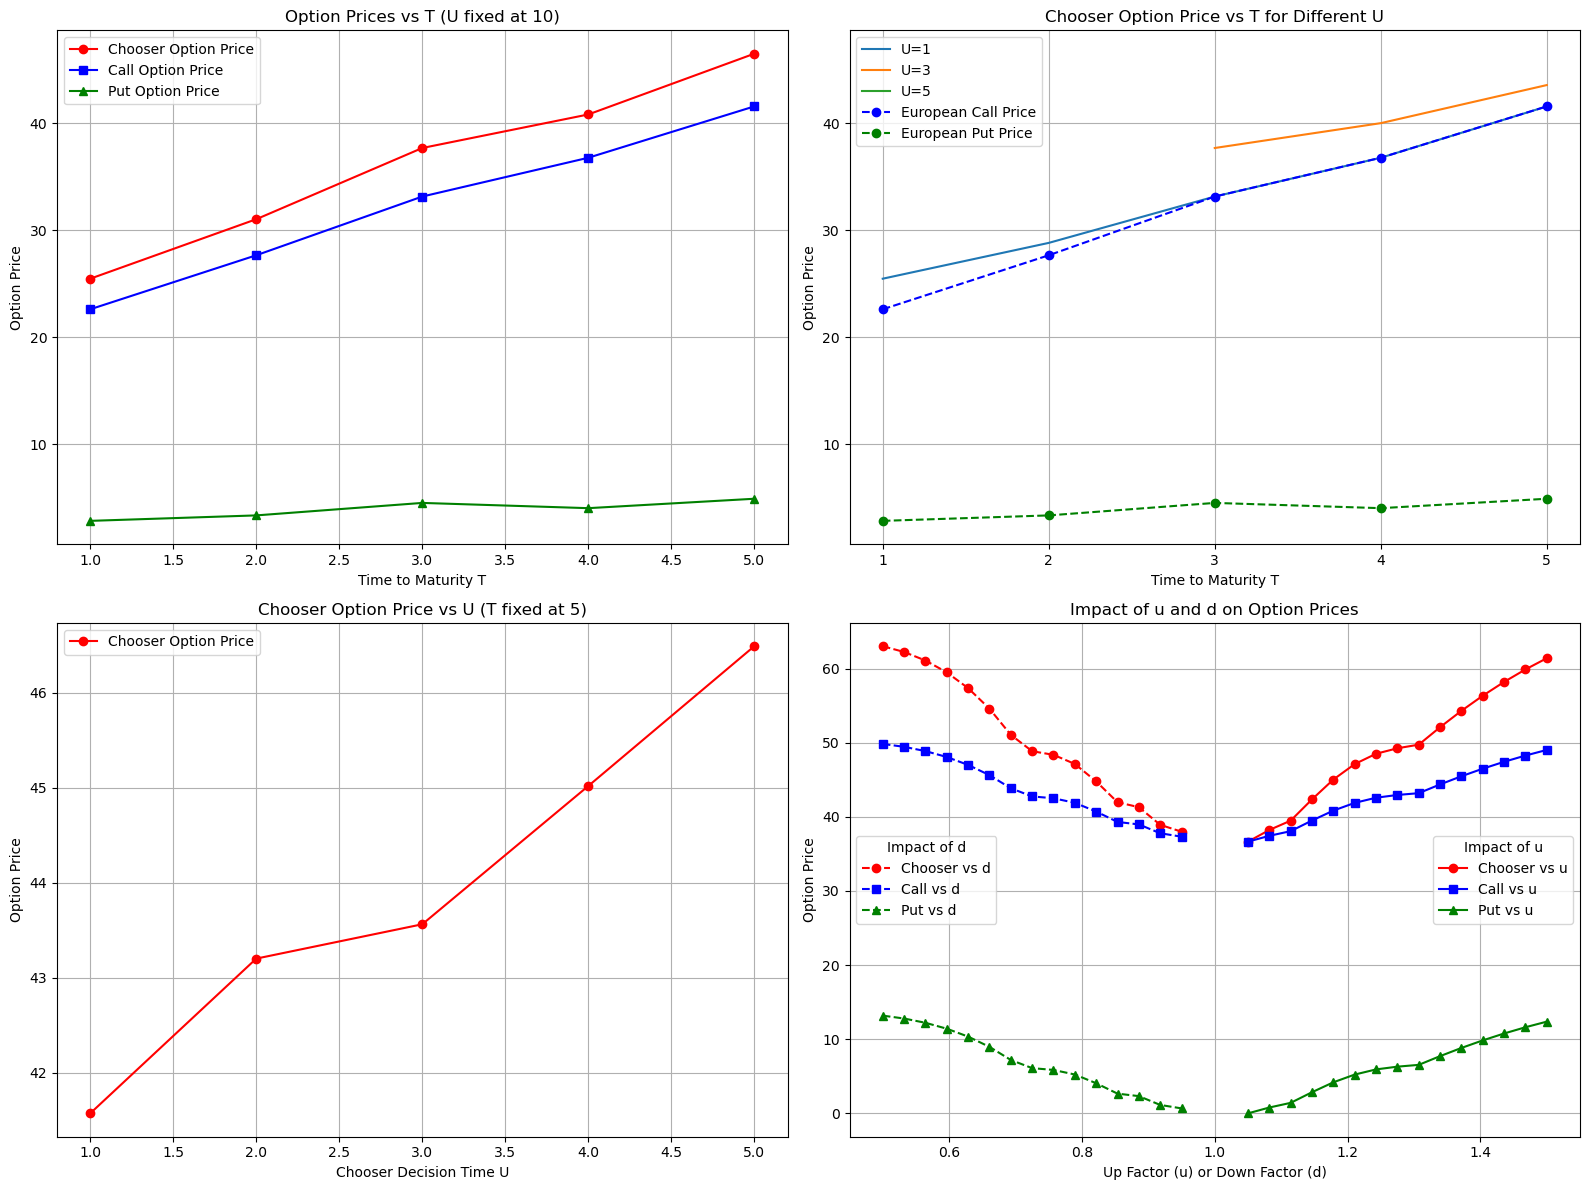

In [7]:
# Create a 2x2 subplot grid for comprehensive analysis
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# 1. Option Prices vs. Time to Maturity (T) - Fixed Decision Time (U)
axs[0, 0].plot(T_range, chooser_prices, marker='o', label='Chooser Option Price', color='r')
axs[0, 0].plot(T_range, call_prices, marker='s', label='Call Option Price', color='b')
axs[0, 0].plot(T_range, put_prices, marker='^', label='Put Option Price', color='g')
axs[0, 0].set_xlabel('Time to Maturity T')
axs[0, 0].set_ylabel('Option Price')
axs[0, 0].set_title(f'Option Prices vs T (U fixed at {U_fixed})')
axs[0, 0].legend()  # Show legend for option types
axs[0, 0].grid(True)  # Add grid for readability

# 2. Chooser Option Prices vs. T - Different Decision Times (U)
def generate_U_list(T):
    """Generate a list of decision times U (step of 2 for clarity)"""
    return list(range(1, T+1, 2))
U_list = generate_U_list(T)

chooser_prices_dict = {}  # Store chooser prices for each U
for U_val in U_list:
    # Only use maturities T that are >= decision time U (valid cases)
    T_valid = [t for t in T_range if t >= U_val]
    if not T_valid:
        continue  # Skip if no valid maturities for current U
    # Calculate chooser prices for valid T
    chooser_prices_U, _, _ = compute_prices_over_T(S0, u, d, r, K, T_valid, U_val)
    chooser_prices_dict[U_val] = chooser_prices_U
    # Plot chooser prices for current U
    axs[0, 1].plot(T_valid, chooser_prices_U, label=f'U={U_val}')

# Add reference lines for European call/put prices
axs[0, 1].plot(T_range, call_prices, marker='o', label='European Call Price', color='b', linestyle='--')
axs[0, 1].plot(T_range, put_prices, marker='o', label='European Put Price', color='g', linestyle='--')
axs[0, 1].set_xlabel('Time to Maturity T')
axs[0, 1].set_ylabel('Option Price')
axs[0, 1].set_title('Chooser Option Price vs T for Different U')
axs[0, 1].set_xticks(T_range)  # Set x-ticks to show all T values
axs[0, 1].legend()
axs[0, 1].grid(True)

# 3. Chooser Option Prices vs. Decision Time (U) - Fixed Maturity (T)
U_range = list(range(1, T + 1))  # Test decision times from 1 to T
# Calculate chooser prices for each U (fixed T)
chooser_prices_over_U = [chooser_pricer(S0, u, d, r, K, T, U_val) for U_val in U_range]
axs[1, 0].plot(U_range, chooser_prices_over_U, marker='o', color='red', label='Chooser Option Price')
axs[1, 0].set_xlabel('Chooser Decision Time U')
axs[1, 0].set_ylabel('Option Price')
axs[1, 0].set_title(f'Chooser Option Price vs U (T fixed at {T})')
axs[1, 0].legend()
axs[1, 0].grid(True)

# 4. Impact of Up (u) and Down (d) Factors on Option Prices
# Generate ranges for u (1.05 to 1.5) and d (0.5 to 0.95) with 15 data points each
u_values = np.linspace(1.05, 1.5, 15)
d_values = np.linspace(0.5, 0.95, 15)
# Lists to store prices for different u and d values
chooser_u, call_u, put_u = [], [], []  # Prices vs. u (fixed d)
chooser_d, call_d, put_d = [], [], []  # Prices vs. d (fixed u)

# Calculate prices for varying u (fixed d)
for u_val in u_values:
    stock_tree_u = build_price_tree(S0, u_val, d, T)
    call_payoff_u = np.maximum(stock_tree_u[:, T] - K, 0)
    put_payoff_u = np.maximum(K - stock_tree_u[:, T], 0)
    chooser_u.append(chooser_pricer(S0, u_val, d, r, K, T, U_fixed))
    call_u.append(option_pricer(call_payoff_u, u_val, d, r, T))
    put_u.append(option_pricer(put_payoff_u, u_val, d, r, T))

# Calculate prices for varying d (fixed u)
for d_val in d_values:
    stock_tree_d = build_price_tree(S0, u, d_val, T)
    call_payoff_d = np.maximum(stock_tree_d[:, T] - K, 0)
    put_payoff_d = np.maximum(K - stock_tree_d[:, T], 0)
    chooser_d.append(chooser_pricer(S0, u, d_val, r, K, T, U_fixed))
    call_d.append(option_pricer(call_payoff_d, u, d_val, r, T))
    put_d.append(option_pricer(put_payoff_d, u, d_val, r, T))

# Plot prices vs. u (solid lines) and vs. d (dashed lines)
axs[1, 1].plot(u_values, chooser_u, 'o-', label='Chooser vs u', color='red')
axs[1, 1].plot(u_values, call_u, 's-', label='Call vs u', color='blue')
axs[1, 1].plot(u_values, put_u, '^-', label='Put vs u', color='green')
axs[1, 1].plot(d_values, chooser_d, 'o--', label='Chooser vs d', color='red')
axs[1, 1].plot(d_values, call_d, 's--', label='Call vs d', color='blue')
axs[1, 1].plot(d_values, put_d, '^--', label='Put vs d', color='green')
axs[1, 1].set_xlabel('Up Factor (u) or Down Factor (d)')
axs[1, 1].set_ylabel('Option Price')
axs[1, 1].set_title('Impact of u and d on Option Prices')

# Create separate legends for u and d impacts
legend_u = axs[1, 1].legend(handles=[
    axs[1, 1].lines[0],
    axs[1, 1].lines[1],
    axs[1, 1].lines[2],
], title="Impact of u", loc='center right', bbox_to_anchor=(1, 0.5))
legend_d = axs[1, 1].legend(handles=[
    axs[1, 1].lines[3],
    axs[1, 1].lines[4],
    axs[1, 1].lines[5],
], title="Impact of d", loc='center left', bbox_to_anchor=(0, 0.5))
axs[1, 1].add_artist(legend_u)  # Keep both legends visible
axs[1, 1].grid(True)

# Adjust layout to prevent overlapping and save the plot
plt.tight_layout()
out_dir = os.path.join(os.getcwd(), "figures")  # Output directory for plots
os.makedirs(out_dir, exist_ok=True)  # Create directory if it doesn't exist
out_path = os.path.join(out_dir, "chooser_plots.png")  # Path to save the plot
plt.savefig(out_path, dpi=200)  # Save plot with 200 DPI resolution
print(f"Plot saved to: {out_path}")
plt.show()  # Display the plot (comment out if only saving is needed)